In [87]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys

In [88]:
%matplotlib notebook

In [89]:
g0 = 9.81

T_C = 28 + 273.15
D = 0.25

r_a = 1.12
r_V = 0.21
r_T = 0.060

T_H = T_C / (1-r_T)  # hot temperature
H = D*r_a  # height
A = np.pi * (D/2)**2

rho0_oil = 1080  # density at room temp
rho0_ss = 1074  # density of ss
c_oil = 1591
c_ss = 3993

V_tot = A * H
m = (V_tot * r_V/(1+r_V)) * rho0_oil

In [129]:
# thermo constants
eta = 1.08e-3  # viscosity of ss (Pa s)
# eta = 0.5
b = 1
# h = 100  # heat transfer coefficient
h = 92.937

k_oil = 0.146
k_ss = 0.596

In [130]:
def rho_oil(T):
    return 958.766 + 1.31955 * T - 0.00307241*T*T

def rho_ss(T):
    return 745.901 + 2.39312 * T - 0.00434063*T*T

In [131]:
def T(x):
    return x/H * (T_C-T_H) + T_H

In [132]:
def f(t, y):
    rho = rho_oil(y[2])
    r = ((3*m/rho)/(4*np.pi))**(1.0/3)
    dx = -g0 + rho_ss(T(y[0]))/rho * g0 - 6*np.pi*eta*r*y[1]/m
    dT = (h*(4*np.pi*r**2)*(T(y[0])-y[2])**b) / (c_oil*m)
    
    if (y[0] >= H):
        y[1] = min(0, y[1])
        dx = min(0, dx)
        
    if (y[0] <= 0):
        y[1] = max(0, y[1])
        dx = max(0,dx)
        
    return [y[1], dx, dT]

In [133]:
t_eval = np.linspace(0, 5000, 10000)
t_eval = np.linspace(0, 200*60, 10000)
# t_eval = np.linspace(0, 30000, 10000)
t_span = (t_eval[0], t_eval[-1])
y0 = [0, 0, T_C]

In [134]:
sol = solve_ivp(f, t_span, y0)

<ipython-input-132-f1eb5e9b086c>:3: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*m/rho)/(4*np.pi))**(1.0/3)


<IPython.core.display.Javascript object>


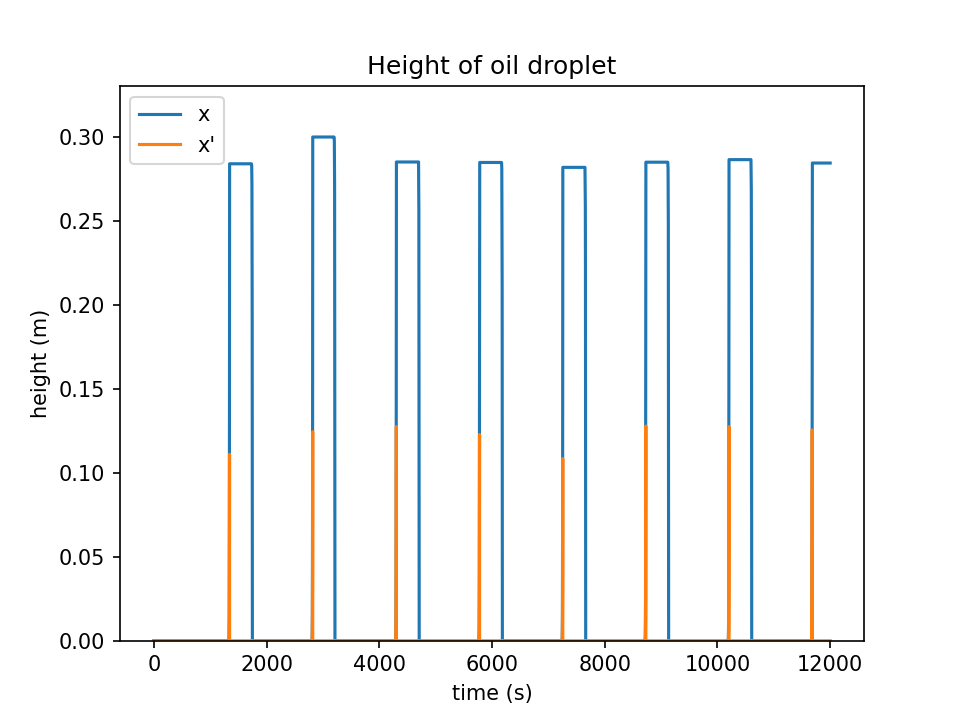

In [135]:
plt.figure()
plt.plot(sol.t, sol.y[0], label='x')
plt.plot(sol.t, sol.y[1], label='x\'')
plt.title('Height of oil droplet')
plt.ylabel('height (m)')
plt.xlabel('time (s)')
plt.ylim(0, H+0.05)
plt.legend()

<IPython.core.display.Javascript object>


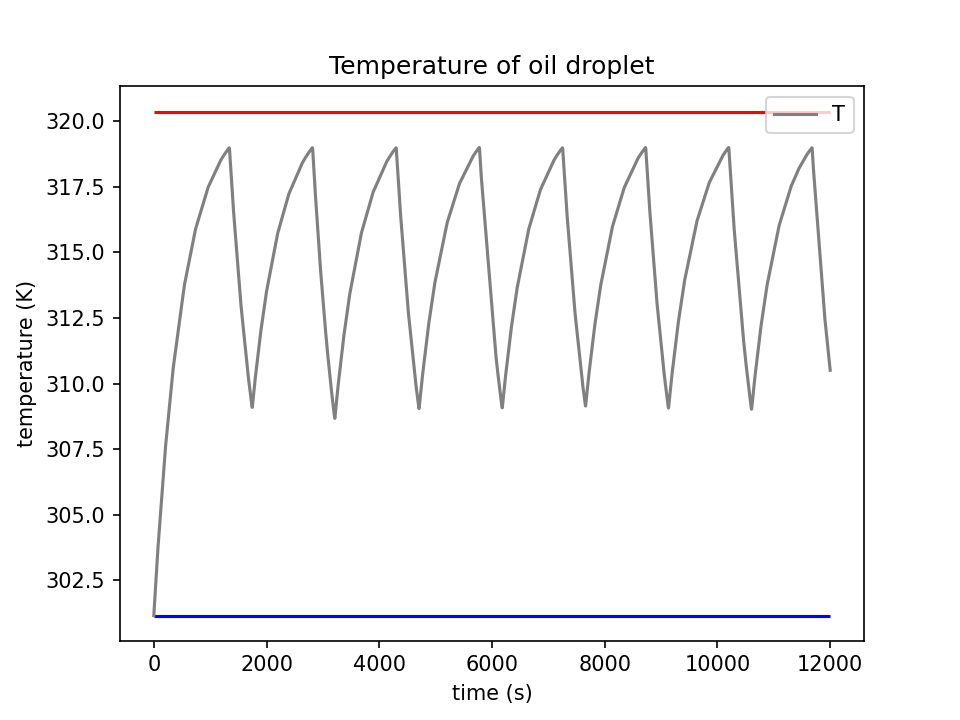

In [136]:
plt.figure()
# plt.plot(sol.t, sol.y[0], label='x')
# plt.plot(sol.t, sol.y[1], label='dx')
plt.plot(sol.t, sol.y[2], label='T', c='gray')
plt.hlines(T_C, t_span[0], t_span[1], colors='blue')
plt.hlines(T_H, t_span[0], t_span[1], colors='red')
plt.title('Temperature of oil droplet')
plt.ylabel('temperature (K)')
plt.xlabel('time (s)')
plt.legend()

<IPython.core.display.Javascript object>


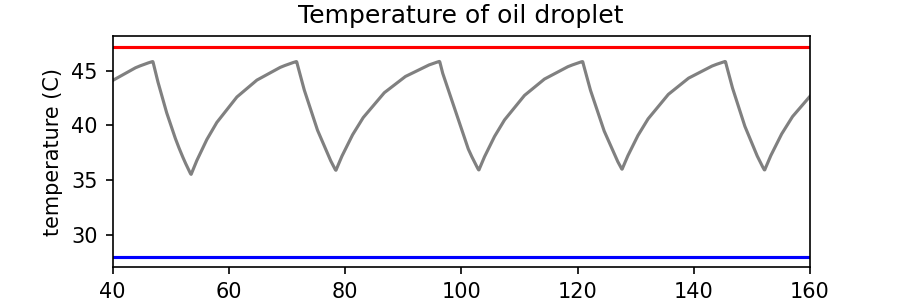

Text(0.5, 0, 'time (minutes)')

In [137]:
plt.figure(figsize=(6, 2))
# plt.plot(sol.t, sol.y[0], label='x')
# plt.plot(sol.t, sol.y[1], label='dx')
plt.plot(sol.t/60, sol.y[2]-273.15, label='T', c='gray')
plt.hlines(T_C-273.15, t_span[0], t_span[1]/60, colors='blue')
plt.hlines(T_H-273.15, t_span[0], t_span[1]/60, colors='red')
plt.xlim(40,160)
plt.title('Temperature of oil droplet')
plt.ylabel('temperature (C)')
plt.xlabel('time (minutes)')
# plt.legend()

<IPython.core.display.Javascript object>


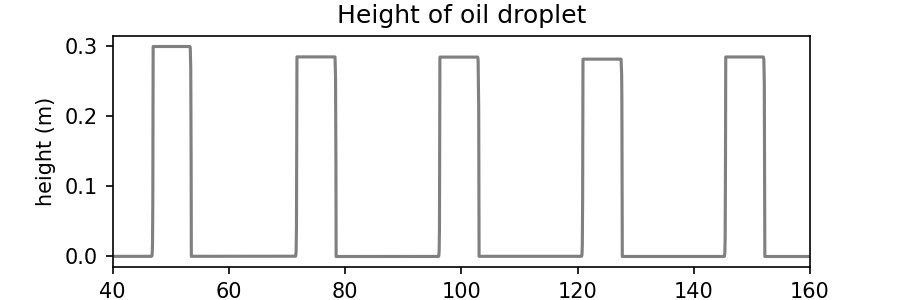

Text(0.5, 0, 'time (minutes)')

In [139]:
plt.figure(figsize=(6, 2))
# plt.plot(sol.t, sol.y[0], label='x')
# plt.plot(sol.t, sol.y[1], label='dx')
plt.plot(sol.t/60, sol.y[0], label='T', c='gray')
plt.xlim(40,160)
plt.title('Height of oil droplet')
plt.ylabel('height (m)')
plt.xlabel('time (minutes)')
# plt.legend()

## temp and height

<IPython.core.display.Javascript object>


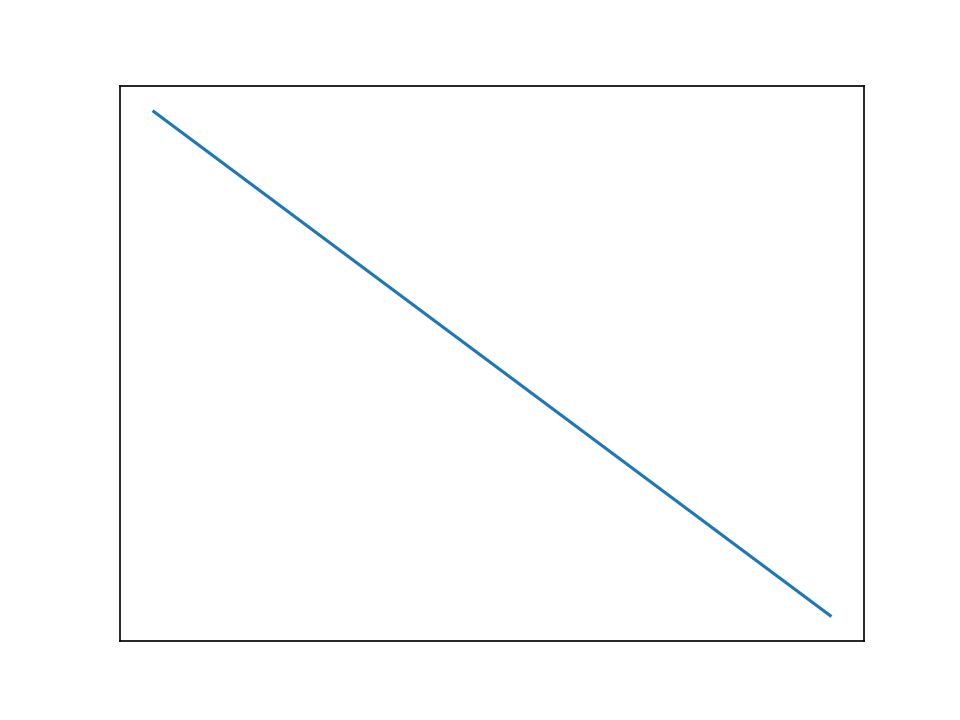

([], [])

In [67]:
plt.figure()
xs = np.linspace(0,H,5)
plt.plot(xs, [T(x) for x in xs])
plt.xticks([])
plt.yticks([])

# Heat transfer coefficient and period of oscillations

In [68]:
def period(sol):
    periods = []
    start = 0
    for i in range(10, len(sol.y[0])):
        if(sol.y[0][i] >= H and sol.y[0][i-1] < H):
            if (start>0):
                periods.append(sol.t[i]-sol.t[start])

            start = i
    
    return np.mean(periods)

In [69]:
H*A*rho0_ss

14.761558481055042

In [72]:
steps = 50
# Hs = np.geomspace(10, 10000, steps)
# Ms = np.geomspace(0.01, 5, steps)
Mus = np.geomspace(1e-4, 1e3, steps)
taus = np.zeros(steps)

In [73]:
for i in range(steps):
    sys.stderr.write(f'{i}\r')
#     h = Hs[i]
#     m = Ms[i]
    eta = Mus[i]
    taus[i] = period(solve_ivp(f, t_span, y0))

<ipython-input-61-f1eb5e9b086c>:3: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*m/rho)/(4*np.pi))**(1.0/3)


KeyboardInterrupt: 

In [78]:
mask = ~(np.isnan(taus) | (taus==0))

In [79]:
taus = taus[mask]
Mus = Mus[mask]

<IPython.core.display.Javascript object>


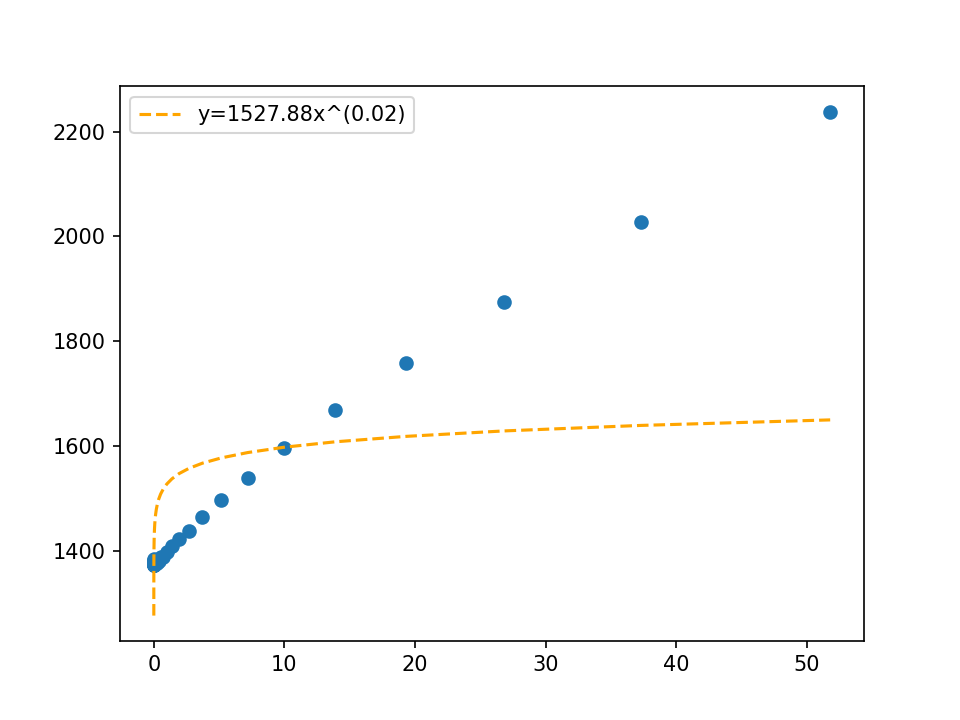

In [82]:
ind_var = Mus

plt.figure()
plt.scatter(ind_var, taus)
# plt.xscale('log')
# plt.yscale('log')
fit = np.polyfit(np.log(ind_var), np.log(taus), 1)
plt.plot(ind_var, np.exp(np.poly1d(fit)(np.log(ind_var))), '--', c='orange', label=f'y={np.exp(fit[1]):.2f}x^({fit[0]:.2f})')
plt.legend()

In [54]:
# plt.xlabel('heat transfer coefficient (W/(K m^2))')
# plt.ylabel('period (s)')

plt.xlabel('mass (g)')
plt.ylabel('period (s)')

Text(24.991542154947915, 0.5, 'period (s)')

# Conduction model

In [130]:
layers = 10
height = H/layers
# T_H_h = 10000
# T_C_h = 10000
T_H_h = 0
T_C_h = 0

In [131]:
# h_ss = 10000
h_ss = 100

In [187]:
def f(t, y):
    delta = np.zeros(layers)
#     delta[0] += T_H_h*A*(T_H-y[0])/(c_ss*rho_ss(y[0])*height*A)
#     delta[layers-1] += T_C_h*A*(T_C-y[layers-1])/(c_ss*rho_ss(y[layers-1])*height*A)
    
#     for i in range(layers-1):
#         # heat capacity
#         s_layer = c_ss*rho_ss(y[i])*height
        
#         if i > 0:
#             # lower layer
#             delta[i] += h_ss*(y[i-1]-y[i])*height/s_layer
        
#         if i < (layers-1):
#             # upper layer
#             delta[i] += h_ss*(y[i+1]-y[i])*height/s_layer

    y_oil = y[layers:]
    if (y_oil[0] >= H):
        y_oil[0] = H
        y_oil[1] = min(0, y_oil[1])
        
    if (y_oil[0] <= 0):
        y_oil[0] = 0
        y_oil[1] = max(0, y_oil[1])
        
    rho = rho_oil(y_oil[2])
    r = ((3*m/rho)/(4*np.pi))**(1.0/3)
    dx = -g0 + rho_ss(T(y_oil[0]))/rho * g0 - 6*np.pi*eta*r*y_oil[1]/m
        
    if (y_oil[0] >= H):
        dx = min(0, dx)
        
    if (y_oil[0] <= 0):
        dx = max(0,dx)
        
    layer_in = int(layers*y_oil[0]/H)
    dQ = (h*(4*np.pi*r**2)*(y[layer_in]-y_oil[2])**b)
    dT = dQ / (c_oil*m)
    y[layer_in] += dQ / (c_ss*rho_ss(y[i])*A*height*0.1)
    print(y[layer_in])
    
    return np.concatenate((delta, [y_oil[1], dx, dT]))

In [188]:
t_eval = np.linspace(0, 2000, 10000)
# t_eval = np.linspace(0, 5000, 10000)
# t_eval = np.linspace(0, 30000, 10000)
t_span = (t_eval[0], t_eval[-1])
y0_oil = [0, 0, T_C]
y0_ss = np.vectorize(T)(np.arange(0, H, height))
y0_ss[layers-1] = T_C
y0 = np.concatenate((y0_ss, y0_oil))

In [189]:
sol = solve_ivp(f, t_span, y0)

320.40470060270377
320.42035514167435
320.4370904656076
320.43707804416124
320.4370162790397
320.43700569025077
320.43699192126303
320.436991345007
320.4690890477327
320.46896700308844
320.4683620285319
320.46825929593524
320.46812628494905
320.46812077228134
320.49691567598404
320.4959229812057
320.4909397490043
320.48990695580903
320.48899286278345
320.4893615819337
320.5015624524365
320.50136960025947
320.4721083344948
320.4139732029984
320.3963345170909
320.49304666364907
320.5088257660535
320.50808970642936
320.50436453242816
320.50354219031107
320.50287732832453
320.50324231190376
320.51595861263905
320.5154766024583
320.5130371112204
320.51249770133455
320.51206277352975
320.5123034791118
320.5168413386143
320.51712117451746
320.4986205490982
320.4566459393711
320.44134913424
320.5145316112648
320.5204729911295
320.52011980645176
320.5182996853225
320.5178459038033
320.5175361013516
320.5178046498745
320.5227636464178
320.5225490107816
320.5214428219335
320.5211667088723
320.520

<ipython-input-187-c439b9be0541>:28: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*m/rho)/(4*np.pi))**(1.0/3)


-0.2625069625561176
-0.5294598370590918
-0.3720052757503084
-0.028090748756256056
320.62618705220154
320.62610999714866
320.6257292483864
320.6256607740271
320.62558550391924
320.625594152802
320.62631868685014
320.62629831344503
320.62619751692273
320.6261804747007
320.6261585328122
320.6261576864082
320.629319146012
320.62929995397997
320.6292050024601
320.6291889485504
320.6291682791184
320.62916748177645
320.63181192790006
320.6316772760376
-0.2611524764860782
-0.37820045287427495
-0.2821277714412418
-0.1212622590818827
320.63210829214626
320.6320731592179
320.63189988896335
320.63187058747434
320.6318339052186
320.63183327938395
320.63216210067213
320.63215207756747
320.6321023807605
320.63209393573436
320.63208298953026
320.6320825290487
320.63498287682665
320.6349731688154
320.6349250343452
320.634916854822
320.63490625274903
320.6349058067343
320.6377151026576
320.6377058243502
320.637659818678
320.637652000083
320.6376418650126
320.6376414383487
320.6377218182939
320.637715828

<IPython.core.display.Javascript object>


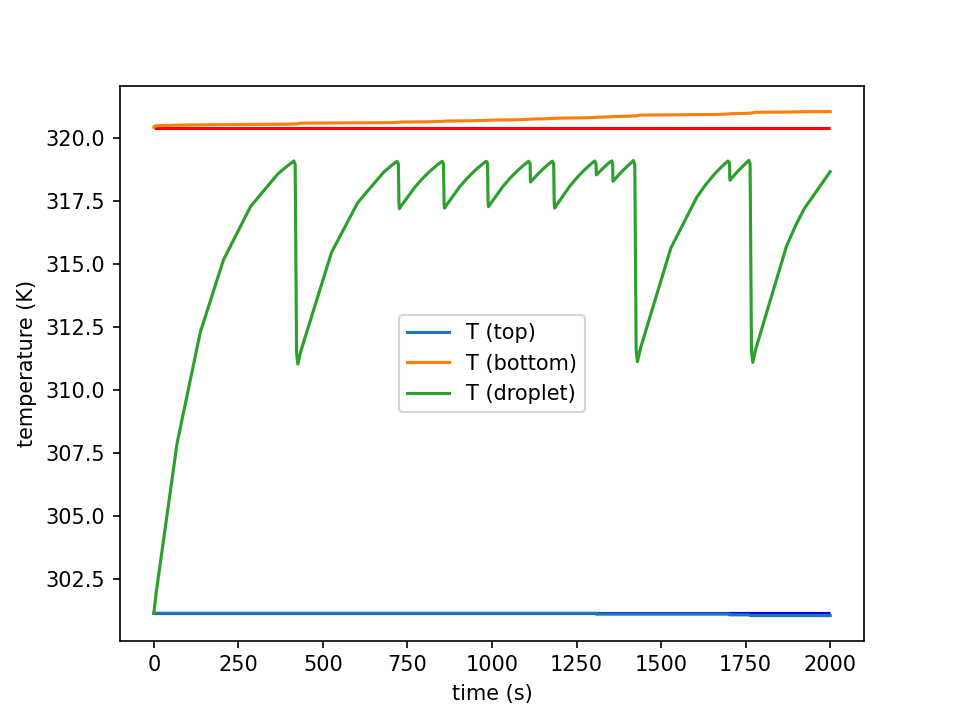

In [190]:
plt.figure()
plt.plot(sol.t, sol.y[layers-1], label='T (top)')
plt.plot(sol.t, sol.y[0], label = 'T (bottom)')
plt.plot(sol.t, sol.y[layers+2], label='T (droplet)')
# for i in range(10):
#     plt.plot(sol.t, sol.y[i], c='gray')

plt.hlines(T_C, t_span[0], t_span[1], colors='blue')
plt.hlines(T_H, t_span[0], t_span[1], colors='red')
# plt.title('Temperature of oil droplet')
plt.ylabel('temperature (K)')
plt.xlabel('time (s)')
plt.legend()